<a href="https://colab.research.google.com/github/Miladatasys/cv-ml-comparison/blob/main/ml_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Construcción del Dataset

## Montaje Drive






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalación de librerías

In [ ]:
!pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Justificación del tema

La elección del tema sobre la clasificación del uso correcto e incorrecto de mascarillas se fundamenta en la relevancia social y sanitaria que esta problemática ha tenido en los últimos años, especialmente durante y después de la pandemia por COVID-19. Aunque el uso de mascarillas se ha vuelto común en espacios públicos, no siempre se utilizan de forma adecuada, lo que reduce significativamente su efectividad.

Este proyecto busca aportar una herramienta automática que pueda identificar, a partir de imágenes, si una persona lleva puesta una mascarilla correctamente, de forma incorrecta o no la lleva. Esta solución tiene aplicaciones prácticas en sistemas de vigilancia, control de acceso o entornos de salud pública, donde el monitoreo automático puede mejorar la seguridad sin intervención humana constante.

## Carga de imágenes con conversión a RGB y separación de canales

En este punto, cargamos y leemos las imágenes con OpenCV organizadas en subdirectorios correspondientes a las 3 clases distintas:

*   'with_mask',
*   'without_mask'
*   'mask_weared_incorrect'
Cada clase contiene inicialmente 89 imágenes, con una ligera variacion en una de las clases (88 imagenes). El conjunto fue dividido manualmente y luego estructurado mediante código en:



  *   Entrenamiento: 183 imagenes totales (61 por clase aprox)
  *   Validación: 81 imagenes totales (27 por clase)



Obtenemos una primera validación de que la lectura se realizó correctamente y que las etiquetas coinciden con las imágenes.



Número de imágenes cargadas: 266
Número de etiquetas cargadas: 266


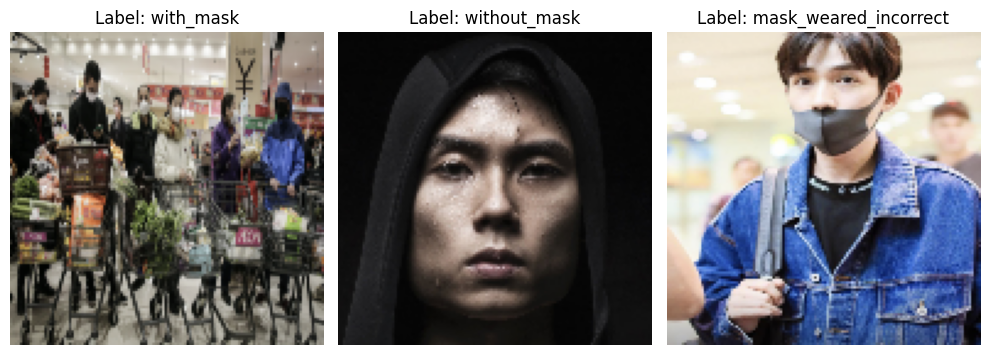

In [ ]:
import random  # Módulo random para obtención de imágenes

# Ruta al dataset
dataset_path = '/content/drive/MyDrive/ComputerVision/dataset/'

# Nombre de las clases que existen en el dataset
target_classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
example_images = {}

# Función para cargar imágenes
def load_images(path, size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                img_path = os.path.join(class_path, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, size)
                    images.append(image)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
images, labels = load_images(dataset_path)
print("Número de imágenes cargadas:", len(images))
print("Número de etiquetas cargadas:", len(labels))

# Mostrar una imagen de ejemplo aleatoria de cada clase objetivo
fig, axes = plt.subplots(1, len(target_classes), figsize=(10, 5))
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
    class_indices = [j for j, label in enumerate(labels) if label == target_class]
    if class_indices:
        # Seleccionar un índice aleatorio de las imágenes pertenecientes a esta clase
        random_index = random.choice(class_indices)
        axes[i].imshow(cv2.cvtColor(images[random_index], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {labels[random_index]}")
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f"No se encontraron ejemplos para: {target_class}", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2.Preprocesamiento con OpenCV

## Operaciones morfológicas

Buscamos refinar las imágenes mediante operaciones morfológicas como dilatación y erosión luego de la conversión a escala de grises, además, elegimos un kernel de 4x4 intentando abordar el ruido y las discontinuidades de las imágenes de mascarillas de manera más efectiva, evitando la distorsión excesiva vista con un kernel de 5x5. Visualmente se percibe una sutil mejora en la conexión de regiones y reducción de ruido sin pérdida drástica de los detalles más importantes del rostro.

<Figure size 1200x400 with 0 Axes>

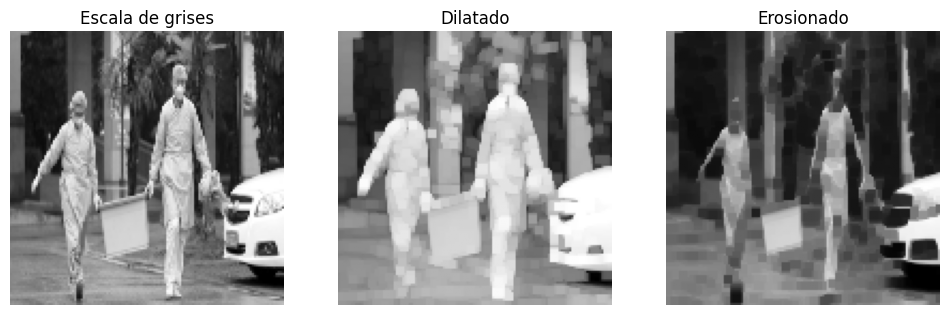

<Figure size 1200x400 with 0 Axes>

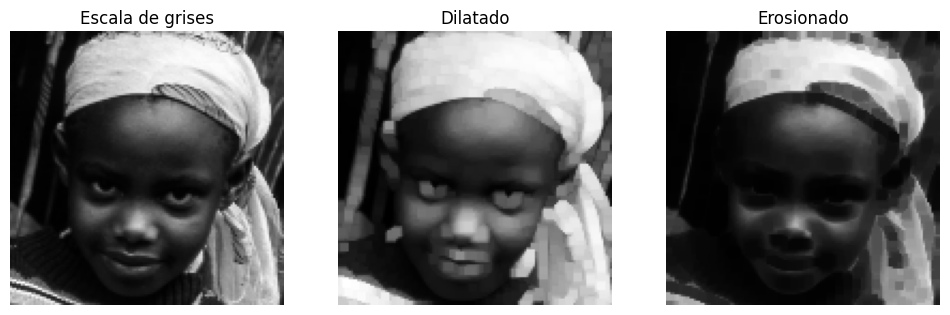

<Figure size 1200x400 with 0 Axes>

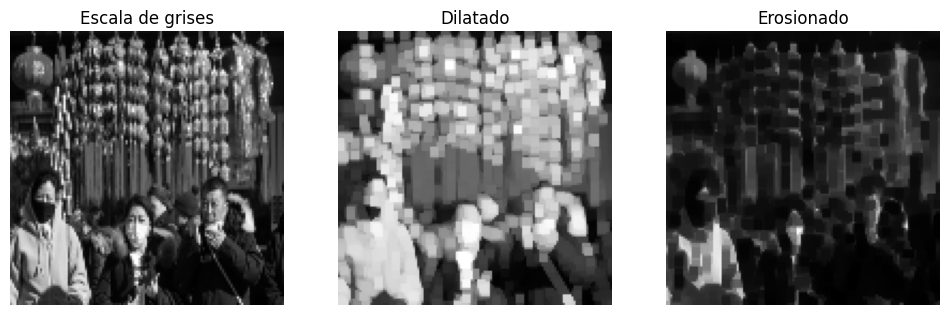

In [ ]:
# Convertir a escala de grises
def apply_morphological_operations(image, kernel_size=(5, 5)):

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kernel = np.ones((4,4), np.uint8)
  dilated = cv2.dilate(gray, kernel, iterations=1)
  eroded = cv2.erode(gray, kernel, iterations=1)
  return gray, dilated, eroded

# Aplicar operaciones morfologicas a una imagen de cada clase
for cls in target_classes:
  # Seleccionar un índice aleatorio de esta clase
  indexes = [i for i, label in enumerate(labels) if label == cls]
  random_index = random.choice(indexes)
  image = images[random_index]

  # Aplicar morfología
  gray, dilated, eroded = apply_morphological_operations(image)

  # Mostrar

  plt.figure(figsize=(12, 4))
  plt.suptitle(f"Operaciones morfológicas - Clase: {cls}", fontsize=14)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(gray, cmap='gray')
  plt.title("Escala de grises")
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(dilated, cmap='gray')
  plt.title("Dilatado")
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(eroded, cmap='gray')
  plt.title("Erosionado")
  plt.axis('off')

  plt.show()

## Filtros convolucionales y segmentación / detección de contornos

En este paso buscamos extraer caracteristicas mediante filtros convolucionales y detección de contornos, comenzando con la conversión a escala de grises para reducir la complejidad y enfocarnos en la forma simplemente. Los filtros Sobel y Laplaciano resaltan bordes pero aumentan ruido, mientras que el Canny resalta los bordes haciendolos más refinados para detectar los contornos.

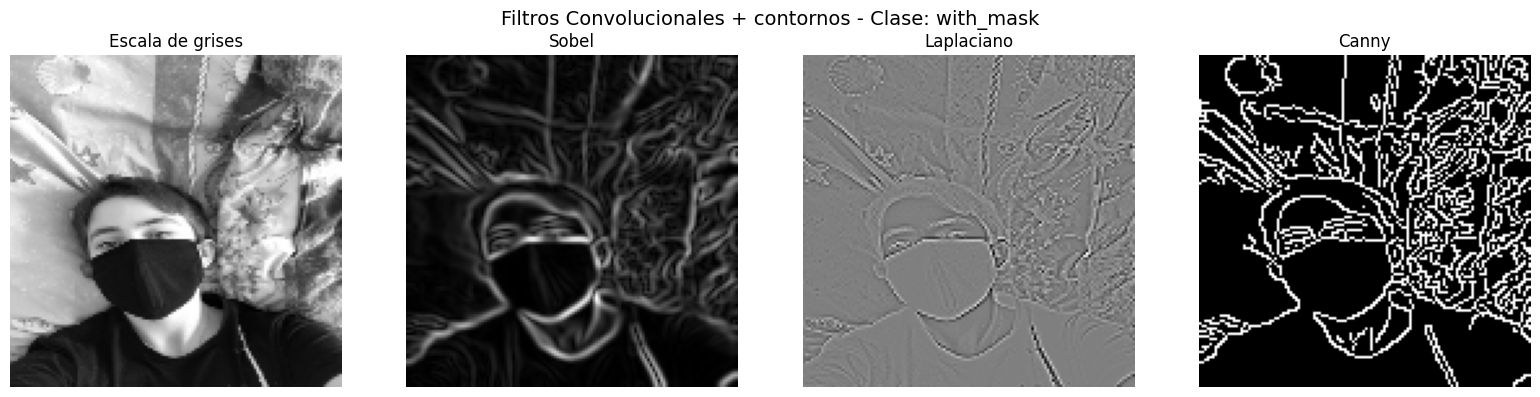

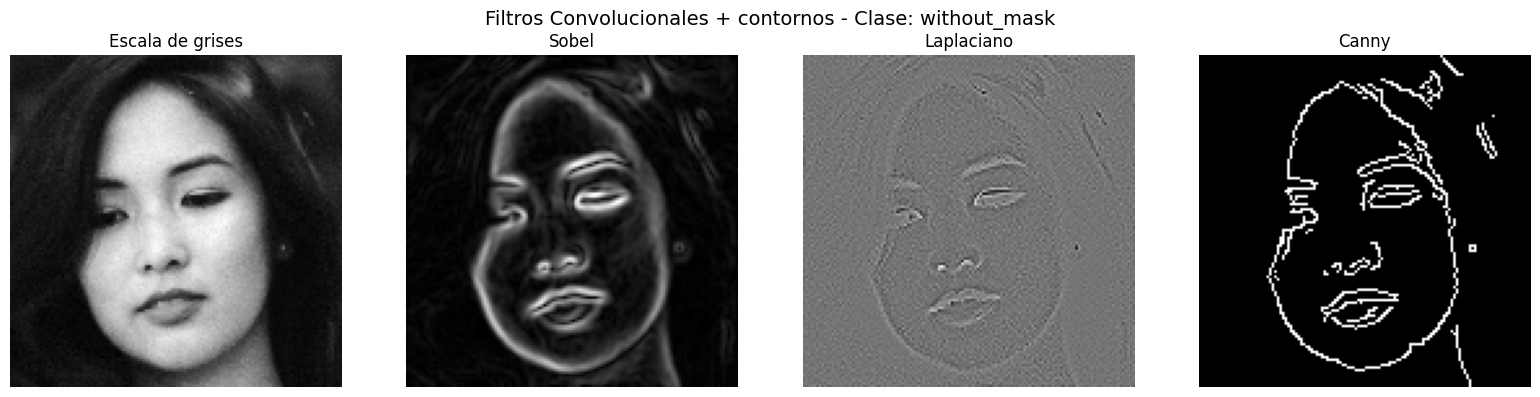

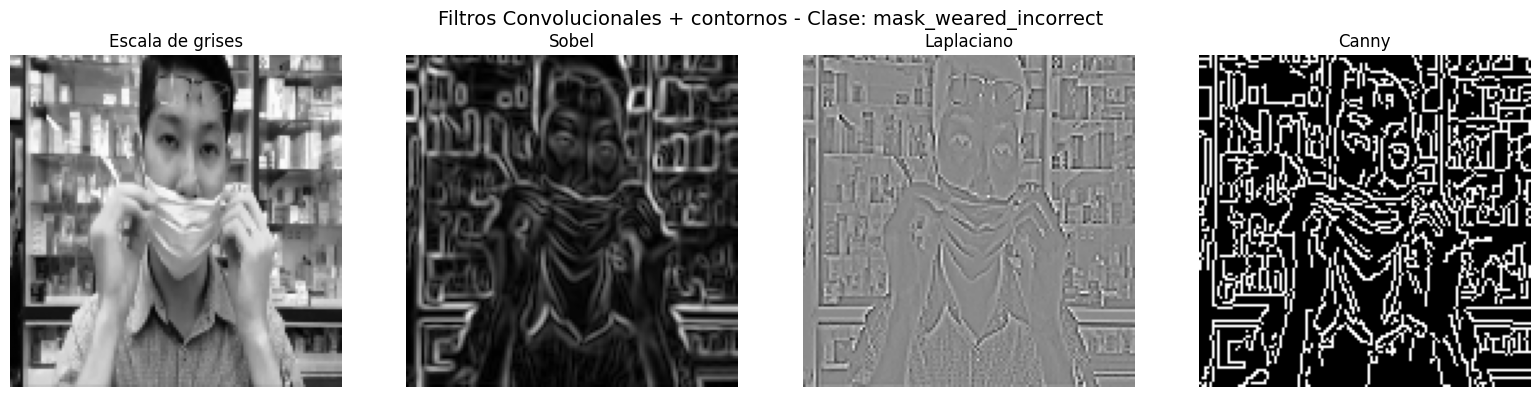

In [ ]:
# Función para aplicar los filtros
def apply_edge_detectors(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Filtro Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  # horizontal
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  # vertical
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # Filtro Laplaciano
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # Filtro Canny
    canny = cv2.Canny(gray, 100, 200)

    return gray, sobel_combined, laplacian, canny


# Aplicar filtros a una imagen de cada clase
for cls in target_classes:
    # Seleccionar un índice aleatorio de esta clase
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Aplicar los filtros
    gray, sobel, laplacian, canny = apply_edge_detectors(image)

    # Detección de contornos
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_img = image.copy()
    cv2.drawContours(contoured_img, contours, -1, (0, 255, 0), 2)

    # Mostrar resultados
    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Filtros Convolucionales + contornos - Clase: {cls}", fontsize=14)

    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Escala de grises")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(sobel, cmap='gray')
    plt.title("Sobel")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(laplacian, cmap='gray')
    plt.title("Laplaciano")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(canny, cmap='gray')
    plt.title("Canny")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Suavizado / Reducción de ruido

Reducimos el ruido mediante filtros de suavizado, incluyendo promedio, gaussiano, mediana y bilateral, aplicados a imagenes de cada clase. La idea de esto es poder mejorar la calidad de las imagenes para etapas posteriores. Los filtros promedio y gaussiano tienden a difuminar los bordes de manera notable, lo que podría resultar perjudicial para detectar el uso de mascarillas, en contraste con el filtro de la mediana y bilateral que ofrecen una mejor respuesta reduciendo ruido y preservando los bordes de mejor manera.

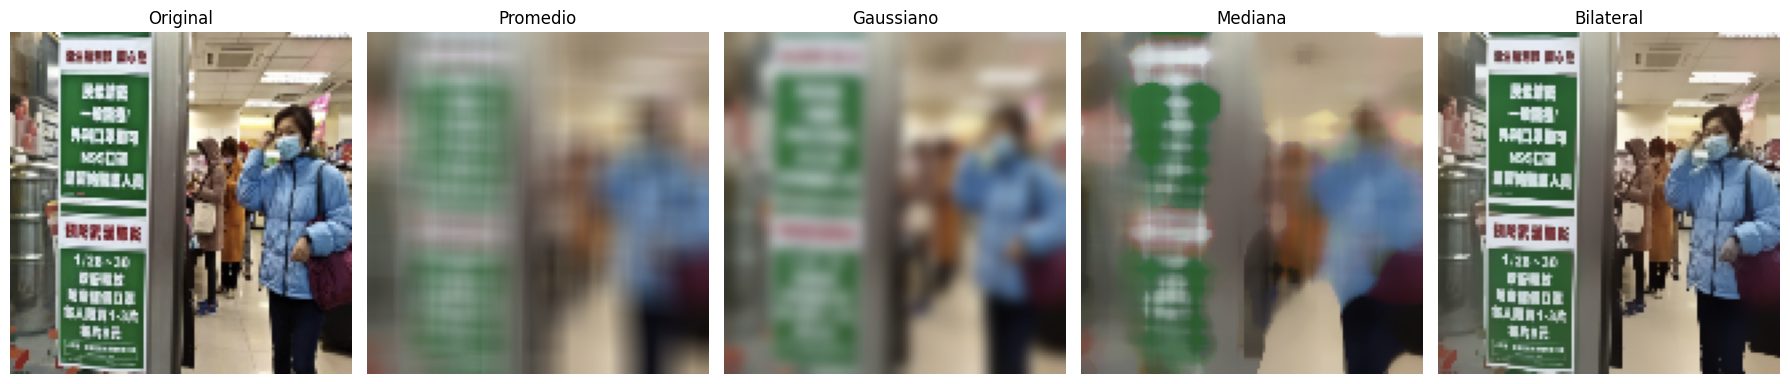

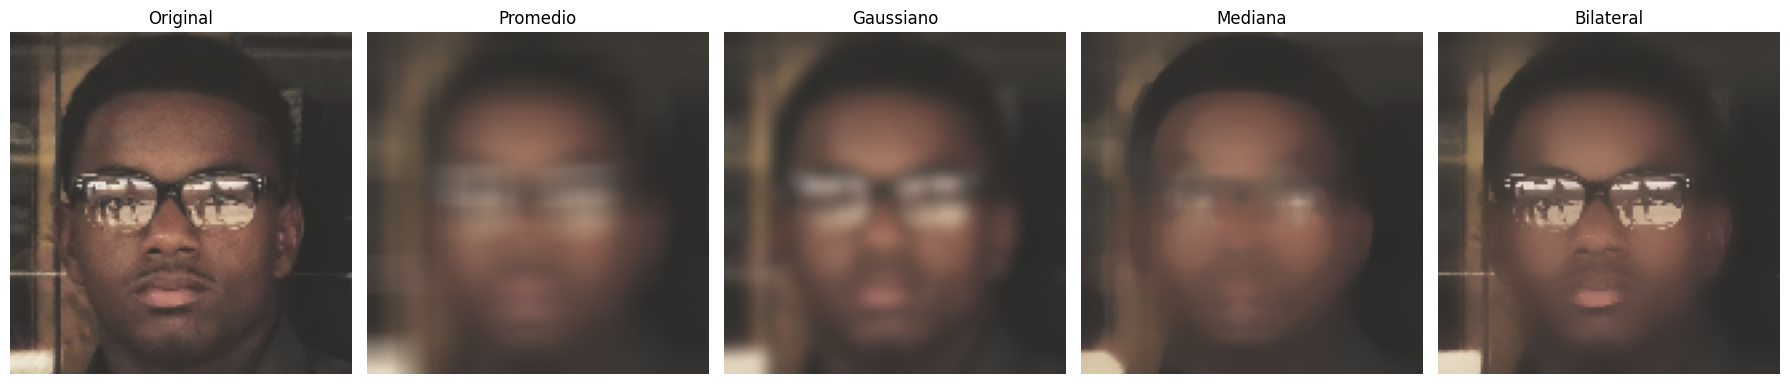

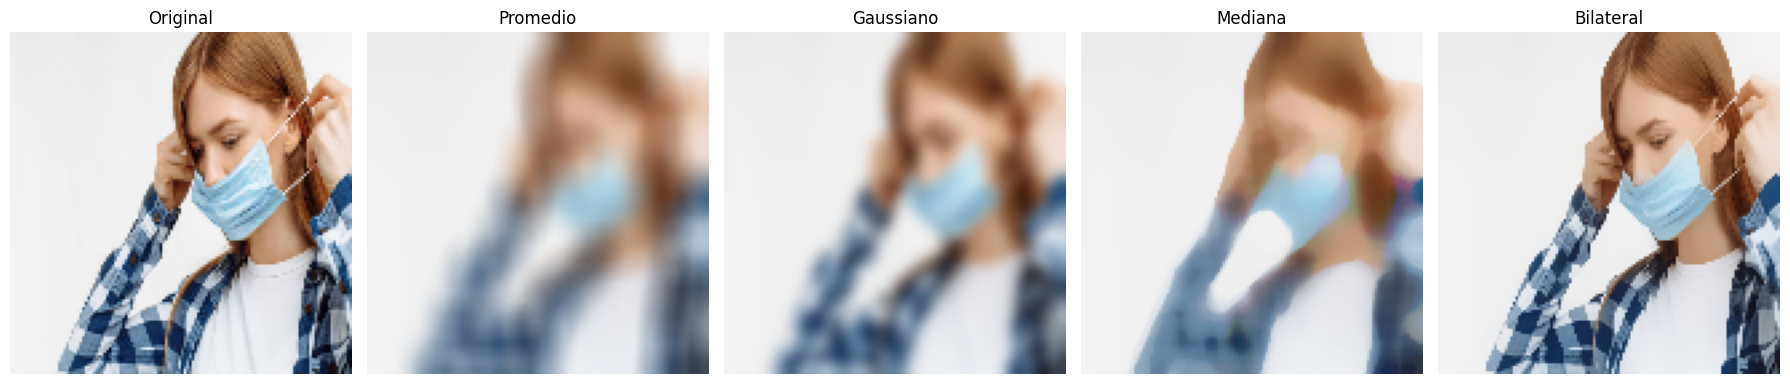

In [ ]:
# Función para mostrar imágenes lado a lado
def mostrar_imagenes(titulos, imagenes):
    plt.figure(figsize=(18,5))
    for i in range(len(imagenes)):
        plt.subplot(1, len(imagenes), i+1)
        img = imagenes[i]
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB
        else:
            plt.imshow(img, cmap='gray')
        plt.title(titulos[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Aplicar suavizados a una imagen por clase
for cls in target_classes:
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Filtros de suavizado
    promedio = cv2.blur(image, (15, 15))
    gauss = cv2.GaussianBlur(image, (15, 15), 0)
    mediana = cv2.medianBlur(image, 15)
    bilateral = cv2.bilateralFilter(image, 15, 75, 75)

    # Mostrar
    mostrar_imagenes(
        ['Original', 'Promedio', 'Gaussiano', 'Mediana', 'Bilateral'],
        [image, promedio, gauss, mediana, bilateral]
    )

## Histogramas

El análisis de los distintos histogramas nos indica que la ecualización es la técnica más consistente y efectiva para mejorar el constraste en las tres clases. En cada aso, la imagen ecualizada presenta una mayor distinción de detalles en comparación con la imagen original. Por otro lado, el estiramiento de contraste resultó ser una técnica inadecuada para el dataset, por la distribución original de la intensidad en los pixeles y llevó a una pérdida de información y sin detalles visibles, concentrando la mayoría de los píxeles en los extremos del rango de intensidad. Por lo tanto, la ecualización se perfila como la mejor técnica para mejorar la calidad del contraste en las imagenes y finalmente para clasificar el uso de mascarilla.

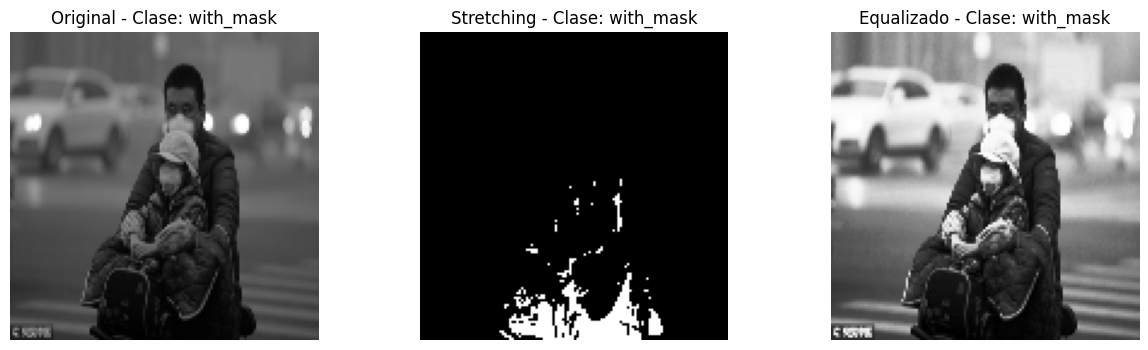

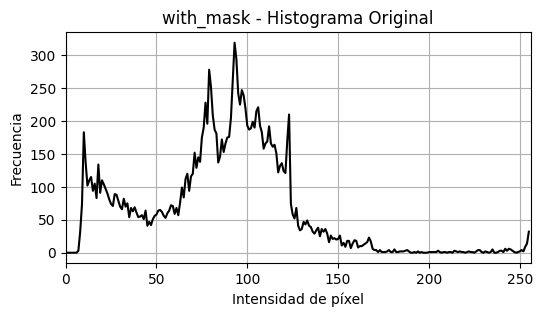

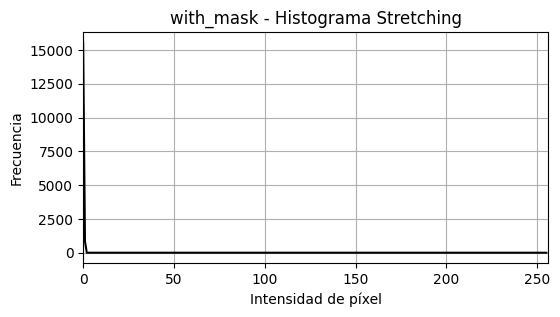

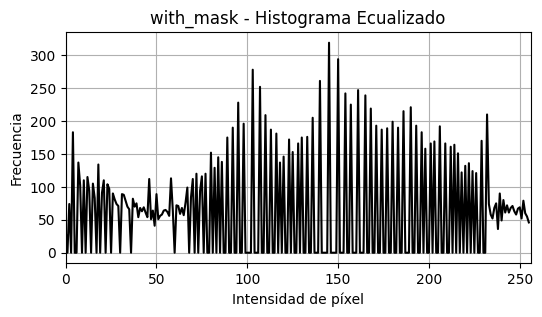

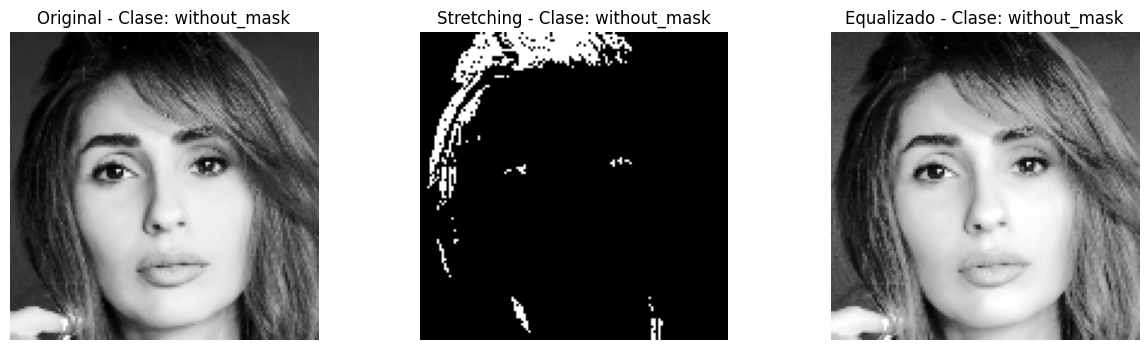

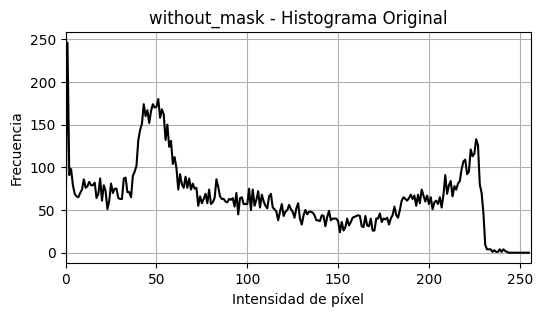

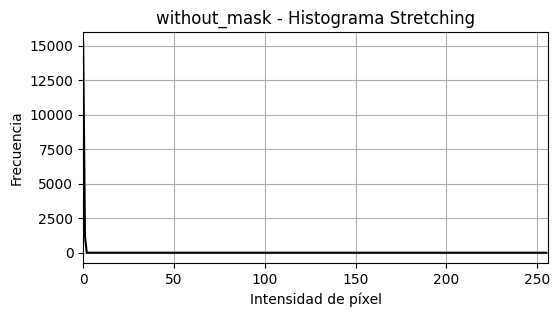

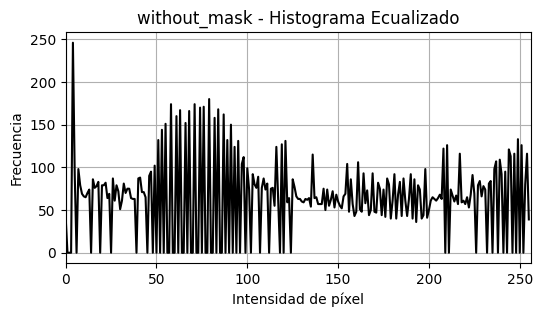

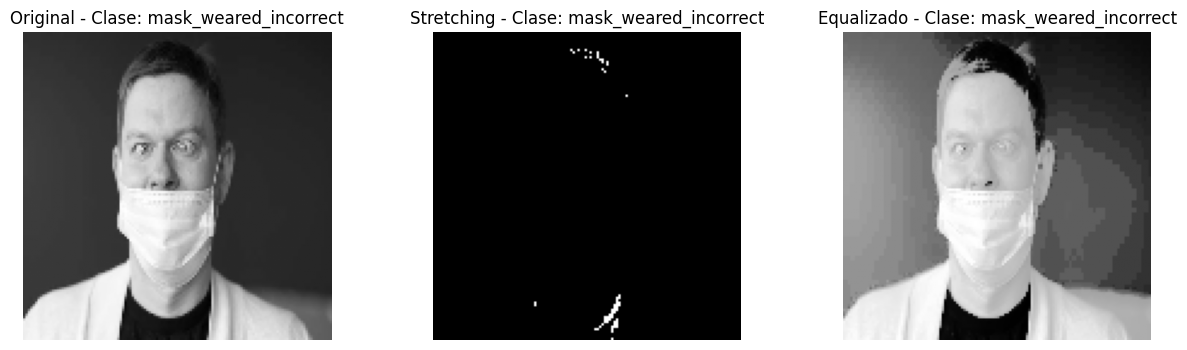

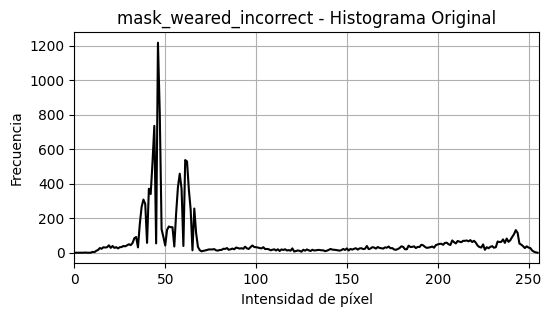

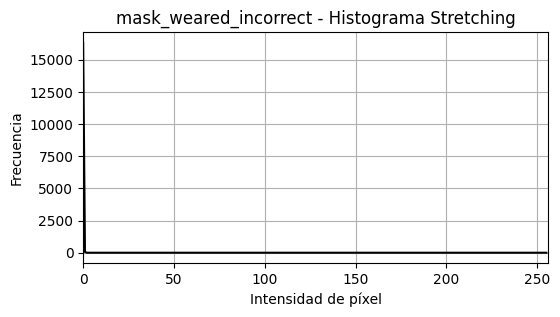

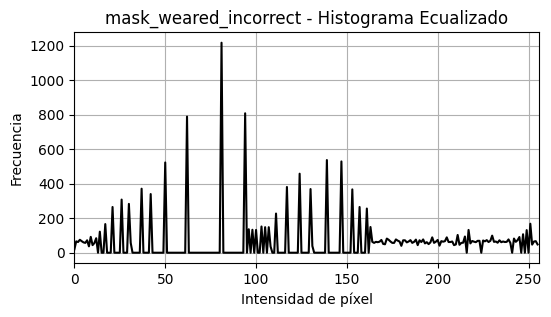

In [ ]:
def graficar_histograma(img, titulo):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.figure(figsize=(6, 3))
    plt.title(titulo)
    plt.plot(hist, color='black')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.xlim([0,256])
    plt.grid()
    plt.show()

# Aplicar análisis de histograma a una imagen por clase
for cls in target_classes:
    indexes = [i for i, label in enumerate(labels) if label == cls]
    random_index = random.choice(indexes)
    image = images[random_index]

    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Estiramiento de contraste
    min_val = np.min(gray)
    max_val = np.max(gray)
    stretch = ((gray - min_val) * 255 / (max_val - min_val)).astype('uint8')

    # Ecualización
    equalized = cv2.equalizeHist(gray)

    # Mostrar imágenes
    plt.figure(figsize=(15, 4))
    titulos = ['Original', 'Stretching', 'Equalizado']
    imagenes = [gray, stretch, equalized]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(imagenes[i], cmap='gray')
        plt.title(f"{titulos[i]} - Clase: {cls}")
        plt.axis('off')
    plt.show()

    # Mostrar histogramas
    graficar_histograma(gray, f"{cls} - Histograma Original")
    graficar_histograma(stretch, f"{cls} - Histograma Stretching")
    graficar_histograma(equalized, f"{cls} - Histograma Ecualizado")

## Descriptores

Implementamos la extracción de tres tipos distintos de descriptores de imagen para cada imagen del dataset:


*   HOG (capturando la forma y los gradientes) representando la distribución de los bordes en diferentes regiones de la imagen. Entendiendo la distribución de la imagen y los contornos que tienen, como los de la cara o mascarilla.

*   LBP ( describiendo la textura local) para micro-texturas como bordes finos, puntos o las distintas variaciones de materiales o texturas de la piel

*   ORB (identificando puntos clave distintivos) Aqui cuantificamos los puntos como esquinas o bordes pronunciados.

Aplicamos un manejo para la dimensionalidad del descriptor ORB y se normalizaron los vectores de características de cada tipo usando Standard Scaler. Una vez normalizado el conjunto de características transformando en un vector numérico de 8100 (HOG), 10 (LBP) y 500 (ORB) dimensiones para poder utilizarlo en el modelo de support vector machine para que este pueda asociar las distintas clases.


In [ ]:
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler

# Parámetros HOG
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
}

# Parámetros LBP
lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'

# Inicializar ORB
orb = cv2.ORB_create()

# Diccionarios para almacenar características por tipo
features_hog = []
features_lbp = []
features_orb = []
labels_all = []

# Recorrer imágenes
for img, label in zip(images, labels):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---- HOG ----
    hog_feat = hog(gray, visualize=False, **hog_params)
    features_hog.append(hog_feat)

    # ---- LBP ----
    lbp = local_binary_pattern(gray, lbp_n_points, lbp_radius, method=lbp_method)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_n_points + 3), range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    features_lbp.append(hist)

    # ---- ORB ----
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    if descriptors is not None:
        orb_desc = descriptors.flatten()
        if orb_desc.shape[0] < 500:  # (rellenar con ceros)
            orb_desc = np.pad(orb_desc, (0, 500 - orb_desc.shape[0]), mode='constant')
        else:
            orb_desc = orb_desc[:500]  # Cortar si es muy largo
    else:
        orb_desc = np.zeros(500)
    features_orb.append(orb_desc)

    labels_all.append(label)

# Convertir a arrays
features_hog = np.array(features_hog)
features_lbp = np.array(features_lbp)
features_orb = np.array(features_orb)
labels_all = np.array(labels_all)

# Normalización
scaler_hog = StandardScaler().fit_transform(features_hog)
scaler_lbp = StandardScaler().fit_transform(features_lbp)
scaler_orb = StandardScaler().fit_transform(features_orb)

# Mostrar tamaños
print("Shape HOG:", scaler_hog.shape)
print("Shape LBP:", scaler_lbp.shape)
print("Shape ORB:", scaler_orb.shape)

Shape HOG: (266, 8100)
Shape LBP: (266, 10)
Shape ORB: (266, 500)


# 3.Implementación de Modelos



Tras entrenar los modelos SVM con las características extraidas (HOG, LBP, ORB) usando las tres clases, se observaron diferencias significativas en el rendimiento:


*   El descriptor HOG mostró una mayor precisión general (71,25%) ya que pudo capturar características relevantes de forma y gradiente, especialmente en la ausencia de mascarilla. En nuestro caso decidimos utilizar un dataset uniforme para cada clase y eso pudo haber determinado la respuesta del modelo en su gran mayoría.

*   El descriptor LBP también mostró una mejora importante tras la limpieza del dataset que realizamos para obtener mejores resultados, alcanzando una precisión del 68,75% al enfocarse en la textura local.

*   En contraste, el descriptor ORB obtuvo el rendimiento mas bajo (47,50%) indicando que esta información por si sola fue menos descriminativa para la tarea de clasificación en comparación con las características de forma y textura.

## Modelo de Machine Learning clásico


 Modelo SVM usando: HOG
Índice de Kappa: 0.5693
Accuracy: 0.7125

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.59      0.73      0.66        26
            with_mask       0.67      0.52      0.58        27
         without_mask       0.89      0.89      0.89        27

             accuracy                           0.71        80
            macro avg       0.72      0.71      0.71        80
         weighted avg       0.72      0.71      0.71        80



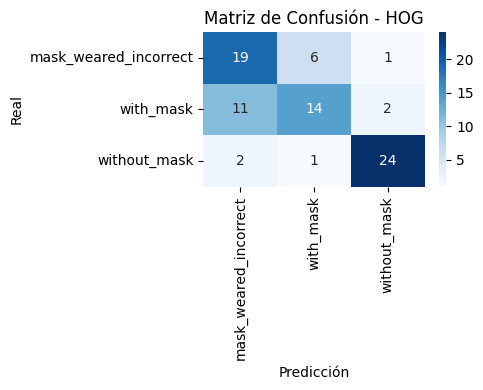


 Modelo SVM usando: LBP
Índice de Kappa: 0.5316
Accuracy: 0.6875

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.57      0.65      0.61        26
            with_mask       0.69      0.67      0.68        27
         without_mask       0.83      0.74      0.78        27

             accuracy                           0.69        80
            macro avg       0.70      0.69      0.69        80
         weighted avg       0.70      0.69      0.69        80



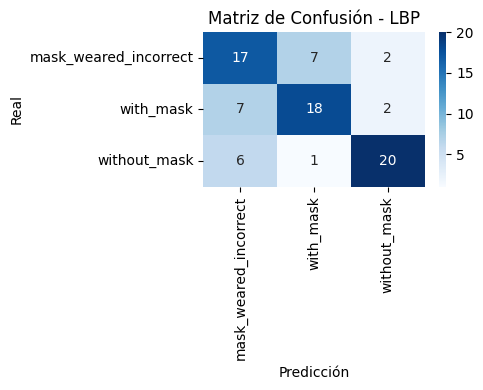


 Modelo SVM usando: ORB
Índice de Kappa: 0.2120
Accuracy: 0.4750

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.50      0.46      0.48        26
            with_mask       0.47      0.52      0.49        27
         without_mask       0.46      0.44      0.45        27

             accuracy                           0.47        80
            macro avg       0.48      0.47      0.47        80
         weighted avg       0.48      0.47      0.47        80



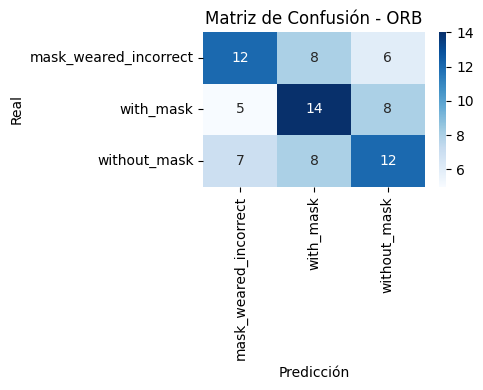

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Función para entrenar, evaluar y mostrar resultados de SVM
def entrenar_svm(X, y, nombre_descriptor):
    print(f"\n Modelo SVM usando: {nombre_descriptor}")

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

    # Crear y entrenar modelo SVM
    model = SVC(kernel='linear', C=1.0, random_state=42)
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)

    # Métrica Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Índice de Kappa: {kappa:.4f}")

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    plt.title(f"Matriz de Confusión - {nombre_descriptor}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    return acc

# Evaluar modelo con cada descriptor
acc_hog = entrenar_svm(scaler_hog, labels_all, "HOG")
acc_lbp = entrenar_svm(scaler_lbp, labels_all, "LBP")
acc_orb = entrenar_svm(scaler_orb, labels_all, "ORB")


## Red neuronal Convolucional

## Descripción de la arquitectura de nuestro CNN

Construimos la CNN utilizando el modelo **sequential** de Keras, con el objetivo de clasificar las imagenes. La red sigue una arquitectura tipica de extracción de características en etapas, donde cada capa cumple con una función especifica en el procesamiento visual.


1.   Capa de entrada: Recibe las imagenes RGB de tamaño 64x64x3 (ancho, alto y canales de color)
2.   Primera capa convolucional(Conv2D): aplica 32 filtros de tamaño 3x3 para detectar bordes y patrones sencillos con la función de activación ReLU
3.   Primera capa de max pooling (MaxPooling2D): reduce el tamaño de la imagen usando una ventana de 2x2, conservando solo la información más importante
4.   Segunda capa convolucional: usa 64 filtros de 3x3 y tambien aplica la activacion ReLU, para detectar ya patrones mas complejos.
5.   Segunda capa de max pooling: Otra reducción de tamaño con una ventana 2x2
6.   Tercera capa convolucional: Aplica 128 filtros de 3x3 con activación ReLU, capaz de capturar detalles y combinaciones de formas más abstractas.
7.   Tercera capa de max pooling: Continúa reduciendo la dimensionalidad para simplificar el aprendizaje.
8.   Flatten: Convierte la salida 2D en un vector 1D para conectarlo con las capas densas (clasificadoras).
9.   Capa densa (Dense): Contiene 256 neuronas con activación ReLU, que actúan como el "cerebro" del modelo para la toma de decisiones.
10.   Dropout: Aplica una tasa de 50%, desactivando aleatoriamente la mitad de las neuronas durante el entrenamiento para evitar sobreajuste.
11.   Capa de salida (Dense): Tiene 3 neuronas (una por clase) y utiliza Softmax, que convierte la salida en una probabilidad para cada categoría.

### División del dataset

In [ ]:
import os
import shutil
import random

# Ruta base
base_dir = '/content/drive/MyDrive/ComputerVision/dataset/'
output_dir = '/content/drive/MyDrive/ComputerVision/split_dataset/'

# Porcentaje de entrenamiento
train_ratio = 0.7

# Clases (carpetas que ya tienes)
clases = ['with_mask', 'without_mask', 'mask_weared_incorrect']

# Crear carpetas destino
for split in ['train', 'val']:
    for clase in clases:
        os.makedirs(os.path.join(output_dir, split, clase), exist_ok=True)

# Dividir imágenes
for clase in clases:
    origen = os.path.join(base_dir, clase)
    archivos = os.listdir(origen)
    random.shuffle(archivos)

    train_cutoff = int(len(archivos) * train_ratio)
    train_imgs = archivos[:train_cutoff]
    val_imgs = archivos[train_cutoff:]

    for img in train_imgs:
        src = os.path.join(origen, img)
        dst = os.path.join(output_dir, 'train', clase, img)
        shutil.copyfile(src, dst)

    for img in val_imgs:
        src = os.path.join(origen, img)
        dst = os.path.join(output_dir, 'val', clase, img)
        shutil.copyfile(src, dst)

print("División completada: train/val listas.")


División completada: train/val listas.


### Entrenamiento de la CNN con Keras

Utilizamos la biblioteca Keras para clasificar las imágenes en sus respectivas categorías. Inicialmente, definimos las rutas de acceso y los conjuntos de datos de entrenamiento y validación. La red neuronal convolucional (CNN) construida sigue un modelo secuencial que extrae características mediante capas convolucionales y de max pooling, y realiza la clasificación con capas densas y Dropout para evitar el sobreajuste, finalizando con una capa softmax que estima las probabilidades de pertenencia a cada clase. El entrenamiento se optimizó utilizando el optimizador Adam y se implementó la técnica de early stopping para evitar sobreentrenamiento. Como resultado, el modelo alcanzó una precisión del 69.14% sobre el conjunto de validación, lo que indica que fue capaz de clasificar correctamente aproximadamente el 69% de las imágenes no vistas. Se utilizó un total de 183 imágenes para entrenamiento y 81 para evaluación, obteniéndose especialmente buenos resultados en la detección de personas sin mascarilla, aunque con ciertas dificultades para distinguir entre mascarillas mal colocadas y bien colocadas.


Found 183 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 650ms/step - accuracy: 0.3267 - loss: 1.1494 - val_accuracy: 0.3333 - val_loss: 1.0633
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 553ms/step - accuracy: 0.3708 - loss: 1.0546 - val_accuracy: 0.6543 - val_loss: 0.8858
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.5803 - loss: 0.8890 - val_accuracy: 0.5802 - val_loss: 0.7441
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step - accuracy: 0.5976 - loss: 0.8612 - val_accuracy: 0.7160 - val_loss: 0.6299
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - accuracy: 0.5986 - loss: 0.7734 - val_accuracy: 0.7160 - val_loss: 0.6420
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 563ms/step - accuracy: 0.6595 - loss: 0.7564 - val_accuracy: 0.6790 - val_loss: 0.6742
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.7453 - loss: 0.5706 - val_accuracy: 0.6914 - val_loss: 0.6135
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step - accuracy: 0.7160 - loss: 0.6169 - val_accuracy: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.5792 - loss: 0.7671

 Evaluación final de la CNN:
Pérdida en validación: 0.6135
Precisión en validación: 0.6914
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step

 Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.59      0.37      0.45        27
            with_mask       0.59      0.74      0.66        27
         without_mask       0.87      0.96      0.91        27

             accuracy                           0.69        81
            macro avg       0.68      0.69      0.67        81
         weighted avg       0.68      0.69      0.67        81



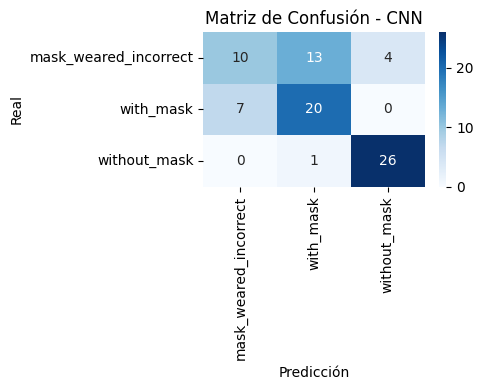


 Índice de Kappa: 0.5370


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Rutas
train_dir = '/content/drive/MyDrive/ComputerVision/split_dataset/train/'
val_dir = '/content/drive/MyDrive/ComputerVision/split_dataset/val/'

# Generadores de datos con data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Construcción del modelo CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # regularización
model.add(Dense(3, activation='softmax'))  # 3 clases

# Compilación
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Guardar modelo
model.save('/content/drive/MyDrive/ComputerVision/modelo_cnn_mascarillas.h5')

# Evaluación final
loss, accuracy = model.evaluate(val_generator)
print(f"\n Evaluación final de la CNN:")
print(f"Pérdida en validación: {loss:.4f}")
print(f"Precisión en validación: {accuracy:.4f}")

# 🔎 Métricas completas

# Predicciones
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Reporte de clasificación
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Matriz de Confusión - CNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Índice de Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"\n Índice de Kappa: {kappa:.4f}")


# 4.Evaluación y comparación

### Analisis

Aunque el modelo SVM alcanzó una precisión ligeramente superior en algunos casos (especialmente con ciertos descriptores como HOG), el modelo de red neuronal convolucional (CNN) mostró un rendimiento más equilibrado y generalizado, como lo evidencia un mayor índice de Kappa (0.537 vs. 0.433). Esto indica una mejor concordancia entre predicciones y etiquetas reales más allá del azar. Además, la CNN logró un F1-score más robusto en la clase "without_mask", aunque tuvo mayores confusiones entre las clases "with_mask" y "mask_weared_incorrect". En contraste, el modelo clásico (SVM) dependía más del tipo de descriptor de características utilizado, lo que puede limitar su capacidad de generalización frente a nuevas imágenes. Si bien la CNN requiere mayor tiempo de entrenamiento y poder computacional, ofrece una solución más integrada y adaptable para tareas de clasificación de imágenes.

Resultados por modelo:



1.   Modelo SVM:
  *   Precisión: 0.73, siendo HOG el descriptor más apto
  *   índice Kappa: 0.43

2.   Modelo CNN:
  *   Precisión: 0.6914
  *   Indice Kappa: 0.5370
  *   F1-score: 0.67

      27 muestras por clase

## Analisis de errores

Una de las principales fallas observadas especialmente en nuestra CNN fue la confusion entre el uso de mascarilla correcto y el uso incorrecto. Es comprensible ya que visualmente ambas clases comparten el uso de mascarillas en el rostro o cubriendo parcialmente. En cambio la clase sin mascarilla fue mucho más precisa por la ausencia total de la mascarilla, es evidente.

Para poder aumentar el desempeño de nuestros modelos, una solución podría ser aumentar el dataset de imágenes o incluso considerar otros modelos que integren detección de registros faciales pero eso aumentaria significativamente la complejidad del trabajo

# 5.Referencias


## Referencias en formato APA

Andrewmvd. (s.f.). Face Mask Detection [Conjunto de datos]. Kaggle. https://www.kaggle.com/datasets/andrewmvd/face-mask-detection&#8203;:contentReference[oaicite:0]{index=0}



Abboah-Offei, M., Salifu, Y., Adewale, B., Bayuo, J., Ofosu-Poku, R., & Opare-Lokko, E. B. A. (2021). A rapid review of the use of face mask in preventing the spread of COVID-19. International journal of nursing studies advances, 3, 100013.